# QAOA

## MAXCUT

### Definitions

In [13]:
# Define graph using vertices and connecting edges
VERTICES = [1, 2, 3, 4]
EDGES = [(1,2), (2,3), (3,4), (4,1)]
GRAPH = [VERTICES, EDGES]

In [51]:
#%%writefile '01_Maxcut.py'
# Import NumPy
import numpy as np
# Import scipy optimization
from scipy.optimize import minimize
# Import mathplotlib
import matplotlib.pyplot as plt
# Import networkx
import networkx as nx
# Import Qiskit
from qiskit import QuantumCircuit,  ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram, plot_state_city
#import qiskit.quantum_info as qi
#from qiskit.providers.aer import AerError
# Initialize a GPU backend
try:
    simulator_gpu = Aer.get_backend('aer_simulator', method="statevector_gpu")
    simulator_gpu.set_options(device='GPU')
    print('Success')
except AerError as e:
    print('Error')
# QAOA circuit
def construct_qaoa(parameters, vertices, edges):
    # Create quantum circuit
    NQUBITS = len(vertices)
    QREG = QuantumRegister(NQUBITS)
    CREG = ClassicalRegister(NQUBITS)
    QC = QuantumCircuit(QREG,CREG)
    # Circuit depth (2 parameters per layer)
    p = int(len(parameters)/2)
    beta = parameters[:p]
    gamma = parameters[p:]
    # Initial state: equal superposition
    for i in range(0,NQUBITS):
        QC.h(i)
    QC.barrier()
    # p layers
    for depth in range(0, p):
        # Apply U_P(\gamma)
        for edge in EDGES:
            QC.rzz(2*gamma[depth], edge[0]-1,edge[1]-1)
        QC.barrier()
        # Apply U_M(\beta)
        for qubit in range(0, NQUBITS):
            QC.rx(2 * beta[depth], qubit)
        QC.barrier()
    QC.measure(QREG,CREG)
    return QC

# Cost function (is minimized)
def cost_fun(bitstring, edges):
    cost = 0
    for i, j in edges:
        if bitstring[i-1] != bitstring[j-1]:
            # Minimization: lower cost = better
            cost -= 1
    return cost

# QAOA circuit execution
def run_qaoa(parameters, vertices, edges, shots):
    qc = construct_qaoa(parameters, vertices, edges)
    job = execute(qc,Aer.get_backend('statevector_simulator'),shots=shots)
    COUNTS = job.result().get_counts(qc)
    return expectation(COUNTS,edges)

# QAOA circuit execution with Nvidia GPU execution
def run_qaoa_gpu(parameters, vertices, edges, shots):
    qc = construct_qaoa(parameters, vertices, edges)
    job = execute(qc,Aer.get_backend('aer_simulator', device='GPU'),shots=shots)
    COUNTS = job.result().get_counts(qc)
    return expectation(COUNTS,edges)

# Expectation value of cost for measuments
def expectation(counts, edges):
    total = 0
    shots = 0
    for bitstring, count in counts.items():
        cost = cost_fun(bitstring, edges)
        total += cost * count
        shots += count
    return total/shots

# Basic implemenation of the simple gradient descent 
def gradient_descent(GRADIENT_FUN, INITIAL, ETA, MAX_ITER=100, EPSILON=0.01):
    vector = np.array(INITIAL)
    learning_rate = ETA
    step_init = 0.05
    step = step_init
    loops = 0
    last_three = [0,0,0]
    LEN = len(INITIAL)
    for i in range(0, MAX_ITER):
        GRAD, value = GRADIENT_FUN(vector, step)
        last_three[loops%3] = value
        diff = - learning_rate * np.array(GRAD)
        if (np.std(np.array(last_three)) <= EPSILON):
            break
        vector += diff
        for index in range(0, len(vector)):
            if np.abs(vector[index]) > 3.15/2:
                vector[index] /= 2
        step = np.min([(np.abs(np.array(diff)).sum()/LEN)/2, step_init])
        loops += 1
        #print(vector)
    return vector.tolist(), loops

# Implemenation of the simple gradient descent with learning schedule
def gradient_descent_scheduled(GRADIENT_FUN, INITIAL, ETA, MAX_ITER=100, EPSILON=0.05):
    vector = np.array(INITIAL)
    learning_rate = ETA
    step_init = 0.05
    step = step_init
    loops = 0
    last_three = [0,0,0]
    LEN = len(INITIAL)
    for i in range(0, MAX_ITER):
        GRAD, value = GRADIENT_FUN(vector, step)
        last_three[loops%3] = value
        diff = - learning_rate * np.array(GRAD)
        if (np.std(np.array(last_three)) <= EPSILON):
            break
        vector += diff
        for index in range(0, len(vector)):
            if np.abs(vector[index]) > 3.15/2:
                vector[index] /= 2
        step = 2/(step+25)
        learning_rate = 1/(learning_rate+20)
        loops += 1
        #print(vector)
    return vector.tolist(), loops

#RMSProp
def RMSProp(GRADIENT_FUN, INITIAL, ETA, GAM, MAX_ITER=100, EPSILON=0.01, log=False):
    if log:
        X_pos = []
        Y_pos = []
    last_three = [0,0,0]
    vector = np.array(INITIAL)
    learning_rate = ETA
    avg_par = GAM
    step = 0.05
    loops = 0
    e_small = 0.01
    LEN = len(INITIAL)
    E = []
    for j in range(0,LEN):
        E.append(0)
    for i in range(0, MAX_ITER):
        if log:
            X_pos.append(vector[0])
            Y_pos.append(vector[1])
        gradient, value = GRADIENT_FUN(vector, step)
        last_three[loops%3] = value
        diff = []
        for j in range(0, LEN):
            E[j] = avg_par * E[j] + (1-avg_par)*(gradient[j]**2)
            diff.append(- (learning_rate/(np.sqrt(E[j])+e_small)) * gradient[j])
        if (np.std(np.array(last_three)) <= EPSILON):
            break
        vector += diff
        #for index in range(0, len(vector)):
        #    if np.abs(vector[index]) > 3.15/2:
        #        vector[index] /= 2
        step = np.min([(np.abs(np.array(diff)).sum()/LEN)/2, 0.05])
        loops += 1
        #print(np.round(gradient,2), np.round(E,2), np.round(last_three,2), np.round(step,4))
        #print(vector)
    if log:
        return vector.tolist(), loops, X_pos, Y_pos
    else:
        return vector.tolist(), loops

# FDSA calculation of gradient
def gradient(point, step, obj_fun):
    grad = []
    for j in range(0,len(point)):
        point_plus = point.copy()
        point_minus = point.copy()
        point_plus[j] += step
        point_minus[j] -= step
        plus = (obj_fun(point_plus))
        minus = (obj_fun(point_minus))
        grad.append((plus-minus)/(2*step))
        avg = (plus + minus)/2
    return grad, avg

# helper functions
def get_run_qaoa(vertices, edges, shots=512):
    def runner(parameters):
        return run_qaoa(parameters, vertices, edges, shots)
    return runner

def get_gradient_qaoa(shots, graph):
    obj = get_run_qaoa(graph[0], graph[1],shots)
    def nabla(point, step):
        return gradient(point, step, obj)
    return nabla


Success


### Simple gradient descent without scheduling

In [15]:
GRAD = get_gradient_qaoa(400, GRAPH)
result1, num_loops = gradient_descent(GRAD, [1.0,1.0], 0.04)

In [16]:
print('Result parameters', result1)
print('Number of gradient calls', num_loops)

Result parameters [0.4042907975578003, 1.2235872036823026]
Number of gradient calls 20


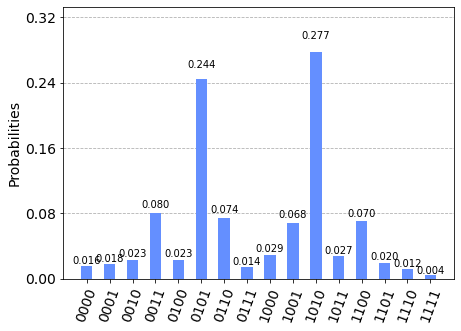

In [17]:
QC1 = construct_qaoa(result1, GRAPH[0], GRAPH[1])
counts1 = execute(QC1,Aer.get_backend('statevector_simulator'),shots=512).result().get_counts()
plot_histogram(counts1)

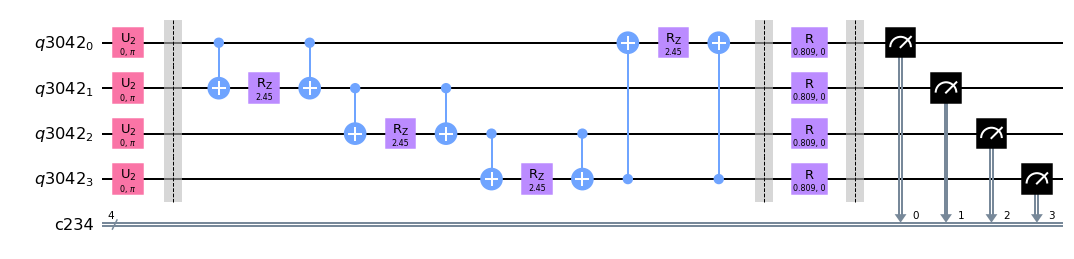

In [18]:
QC1.decompose().draw(output='mpl')

In [19]:
#plot_histogram(counts1, filename='01_Maxcut-histo-01')

### Simple gradient descent with scheduling

In [20]:
GRAD = get_gradient_qaoa(200, GRAPH)
result2, num_loops = gradient_descent_scheduled(GRAD, [2.0,2.0], 0.09)

In [21]:
print('Result parameters', result2)
print('Number of gradient calls', num_loops)

Result parameters [1.2459272687417702, 0.4075269020428688]
Number of gradient calls 6


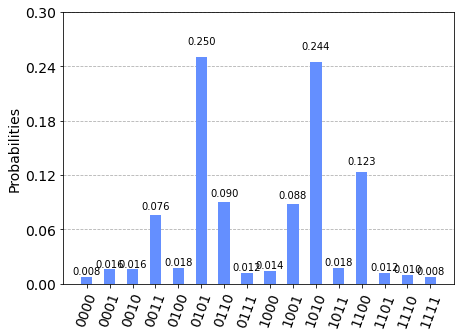

In [22]:
QC2 = construct_qaoa(result2, GRAPH[0], GRAPH[1])
counts2 = execute(QC2,Aer.get_backend('aer_simulator', device='GPU', seed_simulator=10),shots=512).result().get_counts()
plot_histogram(counts2)

In [23]:
#plot_histogram(counts2, filename='01_Maxcut-histo-02')

### RMSProp optimization

In [29]:
GRAD = get_gradient_qaoa(200, GRAPH)
result3, num_loops = RMSProp(GRAD, [1.0,1.0], 0.035, 0.9)

In [30]:
print('Result parameters', result3)
print('Number of gradient calls', num_loops)

Result parameters [1.2666513541626987, 0.3676383673593167]
Number of gradient calls 49


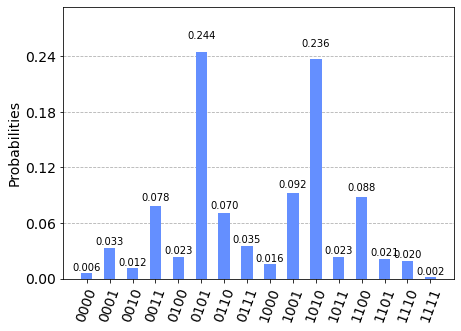

In [31]:
QC3 = construct_qaoa(result3, GRAPH[0], GRAPH[1])
counts3 = execute(QC3,Aer.get_backend('statevector_simulator'),shots=512).result().get_counts()
plot_histogram(counts3)

In [ ]:
#plot_histogram(counts3, filename='01_Maxcut-histo-03')

### Gradient-free optimizer

In [32]:
CIRC = get_run_qaoa(GRAPH[0],GRAPH[1],100)
result4 = minimize(CIRC, [1.0, 1.0], method='COBYLA')
# result4 is not an array!
result4

     fun: -2.9
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 28
  status: 1
 success: True
       x: array([2.03132132, 1.21684853])

In [33]:
QC4 = construct_qaoa(result4.x, GRAPH[0], GRAPH[1])
counts4 = execute(QC4,Aer.get_backend('statevector_simulator'),shots=512).result().get_counts()
plot_histogram(counts4)

In [34]:
#plot_histogram(counts4, filename='01_Maxcut-histo-04')

In [35]:
import qiskit.tools.jupyter
%qiskit_version_table

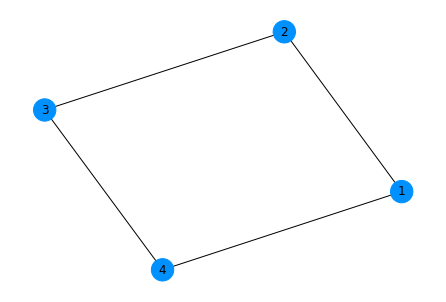

In [40]:
ctublue = '#0091ff'
ctuoran = '#ff6e00'
color_map = []
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4])
G.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 1)])
graph1 = plt.figure()
for node in G.nodes():
    color_map.append(ctublue)
nx.draw(G, node_color=color_map, with_labels=True, node_size=500)
graph1.savefig("01-Maxcut-graph-0.png")

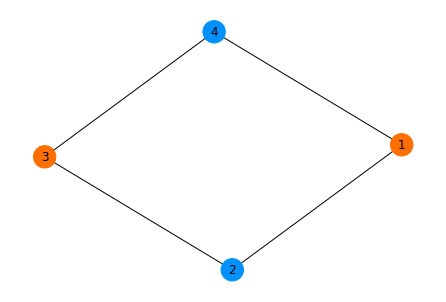

In [41]:
color_map = []
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4])
G.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 1)])
graph1 = plt.figure()
for val in [0,1,0,1]:
    if val:
        color_map.append(ctublue)
    else:
        color_map.append(ctuoran)
nx.draw(G, node_color=color_map, with_labels=True, node_size=500)
graph1.savefig("01-Maxcut-graph-1.png")

In [42]:
color_map = []
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4])
G.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 1)])
graph1 = plt.figure()
for val in [1,0,1,0]:
    if val:
        color_map.append(ctublue)
    else:
        color_map.append(ctuoran)
nx.draw(G, node_color=color_map, with_labels=True, node_size=500)
graph1.savefig("01-Maxcut-graph-2.png")

In [52]:
PERF = np.zeros((4,5))
for i in range(5):
    LOOPS2 = []
    GRAD = get_gradient_qaoa(300, GRAPH)
    for index in range(20):
        result_tmp1, num_loops_tmp1 = gradient_descent(GRAD, [1.0,1.0], 0.04,30,0.01*(i+1))
        LOOPS2.append(num_loops_tmp1)
    LOOPS2 = np.array(LOOPS2)
    print(LOOPS2.sum(), np.mean(LOOPS2))
    PERF[0,i] = np.mean(LOOPS2)
    LOOPS3 = []
    GRAD = get_gradient_qaoa(300, GRAPH)
    for index in range(20):
        result_tmp1, num_loops_tmp1 = gradient_descent_scheduled(GRAD, [1.0,1.0], 0.04, 30,0.01*(i+1))
        LOOPS3.append(num_loops_tmp1)
    LOOPS3 = np.array(LOOPS3)
    print(LOOPS3.sum(), np.mean(LOOPS3))
    PERF[1,i] = np.mean(LOOPS3)
    LOOPS4 = []
    for index in range(20):
        CIRC_tmp = get_run_qaoa(GRAPH[0],GRAPH[1],300)
        result_tmp2 = minimize(CIRC_tmp, [1.0, 1.0], method='COBYLA',tol=0.01*(i+1),\
                               options={'maxiter':30,'disp':False})
        LOOPS4.append(result_tmp2.nfev)
    LOOPS4 = np.array(LOOPS4)
    print(LOOPS4.sum(), np.mean(LOOPS4))
    PERF[2,i] = np.mean(LOOPS4)
    LOOPS1 = []
    GRAD = get_gradient_qaoa(300, GRAPH)
    for index in range(20):
        result_tmp1, num_loops_tmp1 = RMSProp(GRAD, [1.0,1.0], 0.035, 0.9 ,20,0.01*(i+1))
        LOOPS1.append(num_loops_tmp1)
    LOOPS1 = np.array(LOOPS1)
    print(LOOPS1.sum(), np.mean(LOOPS1))
    PERF[3,i] = np.mean(LOOPS1)

541 27.05
339 16.95
366 18.3
356 17.8
391 19.55
252 12.6
341 17.05
224 11.2
341 17.05
170 8.5
291 14.55
215 10.75
244 12.2
157 7.85
284 14.2
194 9.7
200 10.0
152 7.6
279 13.95
123 6.15


In [53]:
print(PERF)

[[27.05 19.55 17.05 12.2  10.  ]
 [16.95 12.6   8.5   7.85  7.6 ]
 [18.3  17.05 14.55 14.2  13.95]
 [17.8  11.2  10.75  9.7   6.15]]


In [54]:
np.savetxt('01PERF.txt', PERF)